# Segmenting Credit Card Customers Using the K-Means Algorithm

## Table of Contents

- [1. Introduction](#1.-Introduction)
- [2. Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)
- [3. Feature Engineering](#3.-Feature-Engineering)
- [4. Data Scaling](#4.-Data-Scaling)
- [5. Choosing K](#5.-Choosing-K)
- [6. Analyzing the Results](#6.-Analyzing-the-Results)
- [7. Conclusion](#7.-Conclusion)

## 1. Introduction

In this project, we’ll assume the role of a data scientist working for a credit card company. The dataset we'll work with contains information about the company’s clients, and we are tasked with segmenting them into different groups to apply various business strategies for each type of customer. For instance, the company could provide higher credit limits to customers who frequently use their credit cards but spend little money, or create incentives for high-income customers who don't use their cards as much as the company expects.

Fortunately, the data engineering team has already cleaned most of the data. Additionally, in a planning meeting with the Data Science coordinator, it was decided that we should use the **K-means** algorithm to segment the data. The company expects to receive a group assignment for each client, along with an explanation of the characteristics of each group and the main points that differentiate them.

To use the K-means algorithm properly and achieve all the goals the company has set for us, we will go through the following steps:
1. Analyze the dataset.
2. Prepare the data for modeling.
3. Find the appropriate number of clusters.
4. Segment the data.
5. Interpret and explain the results.

Furthermore, here is the data dictionary:
- `customer_id` – Unique identifier for each customer.
- `age` – Customer's age in years.
- `gender` – Customer's gender (`M` or `F`).
- `dependent_count` – Number of dependents.
- `education_level` – Level of education (e.g. `High School`, `Graduate`).
- `marital_status` – Marital status (e.g. `Single`, `Married`).
- `estimated_income` – Estimated income projected by the data science team (in `USD`).
- `months_on_book` – Time as a customer in months.
- `total_relationship_count` – Number of contacts the customer had with the company.
- `months_inactive_12_mon` – Number of inactive months in the last `12` months.
- `credit_limit` – Customer's credit limit (in `USD`).
- `total_trans_amount` – Total amount spent using the card (in `USD`).
- `total_trans_count` – Total number of card transactions.
- `avg_utilization_ratio` – Average daily utilization ratio.

Let's start by importing the necessary libraries and defining a function to format tick labels with commas, which will be useful when creating graphs.

In [1]:
# Import the relevant libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Define a function to format tick labels with commas
def format_ticks(value, tick_number):
    return f'{int(value):,}'

## 2. Exploratory Data Analysis

To explore our data, let's investigate the size of the dataset, the columns it contains, the type of each column, and check for any missing values.

In [2]:
# Load the dataset and display the first few rows and dataset information
customers = pd.read_csv('Datasets/customer_segmentation.csv')
display(customers.head())
display(customers.info())

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

None

There are `10,127` rows and `14` columns in the dataset. The unique identifier for each client will not be needed for segmentation, so we can omit it. Of the remaining `13` columns, `8` contain integers, `2` contain floats, and `3` contain strings representing the categorical columns. Additionally, there are no missing values.

In [3]:
# Drop the 'customer_id' column from the DataFrame
customers.drop('customer_id', axis=1, inplace=True)

# Display the value counts for categorical columns
for column in ['gender', 'education_level', 'marital_status']:
    display(customers[column].value_counts())

gender
F    5358
M    4769
Name: count, dtype: int64

education_level
Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: count, dtype: int64

marital_status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: count, dtype: int64

We see that the dataset has `5,358` female and `4,769` male customers. Most customers have a `Graduate` level education, followed by `High School`, `Uneducated`, and `College`. Moreover, marital status shows a majority of `Married` customers, followed by `Single`, `Unknown`, and `Divorced`.

Since we're working with unsupervised machine learning, there isn't a target variable on which we can measure the impacts of the other variables. However, we can examine the correlation between the numeric variables and their distributions.

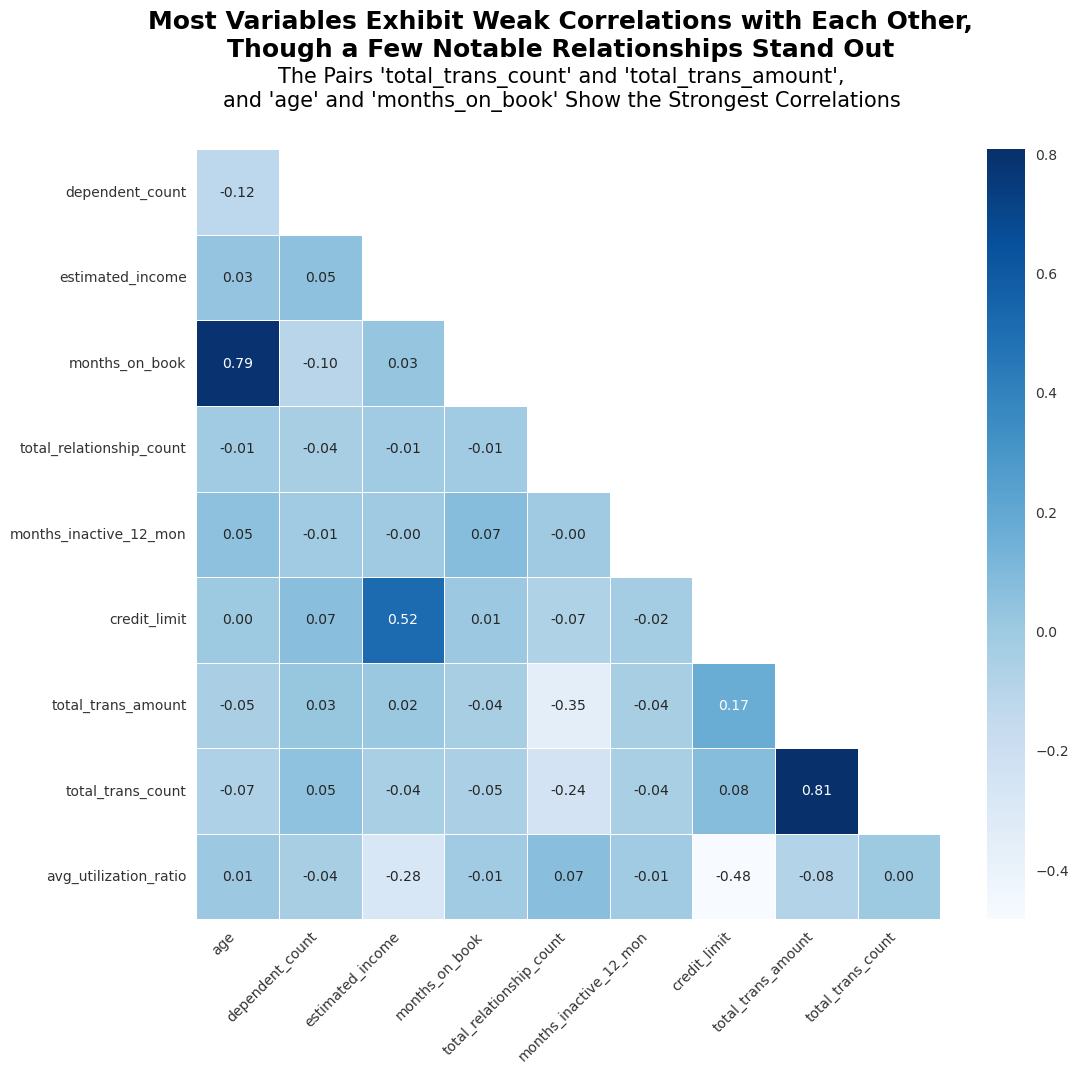

In [4]:
# Select only numeric columns and compute their correlations
customers_numeric = customers.select_dtypes(include=['number'])
corr_matrix = customers_numeric.corr().iloc[1:, :-1]

# Create a mask for the upper triangle of the correlation matrix
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap of the correlations with annotations
fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 10},
                 linewidths=0.5, cmap="Blues", fmt=".2f", mask=mask)

# Set a title and a subtitle
ax.set_title("Most Variables Exhibit Weak Correlations with Each Other,\n\
Though a Few Notable Relationships Stand Out", 
             x=0.49, y=1.11, fontsize=18, ha='center', weight='bold')
ax.text(s="The Pairs 'total_trans_count' and 'total_trans_amount',\n\
and 'age' and 'months_on_book' Show the Strongest Correlations",
        x=4.42, y=-0.5, fontsize=15, ha='center')

# Customize tick parameters and rotate x-tick labels
ax.tick_params(left=False, bottom=False)
ax.tick_params(axis='both', labelsize=10, labelcolor='#333333')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust the size and color of the colorbar values, and remove tick marks
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelcolor='#333333', labelsize=10, right=False)

# Display the plot
plt.show()

Most variables exhibit weak correlations with each other, but a few notable relationships stand out:

- The total number of transactions (`total_trans_count`) is very strongly correlated with the total amount spent (`total_trans_amount`), showing the highest correlation among all numeric variables.
- Age has a strong correlation (`0.79`) with the duration of customer membership (`months_on_book`).
- Credit limit is positively correlated with estimated income (`0.52`) and negatively correlated with the average utilization ratio (`-0.48`).

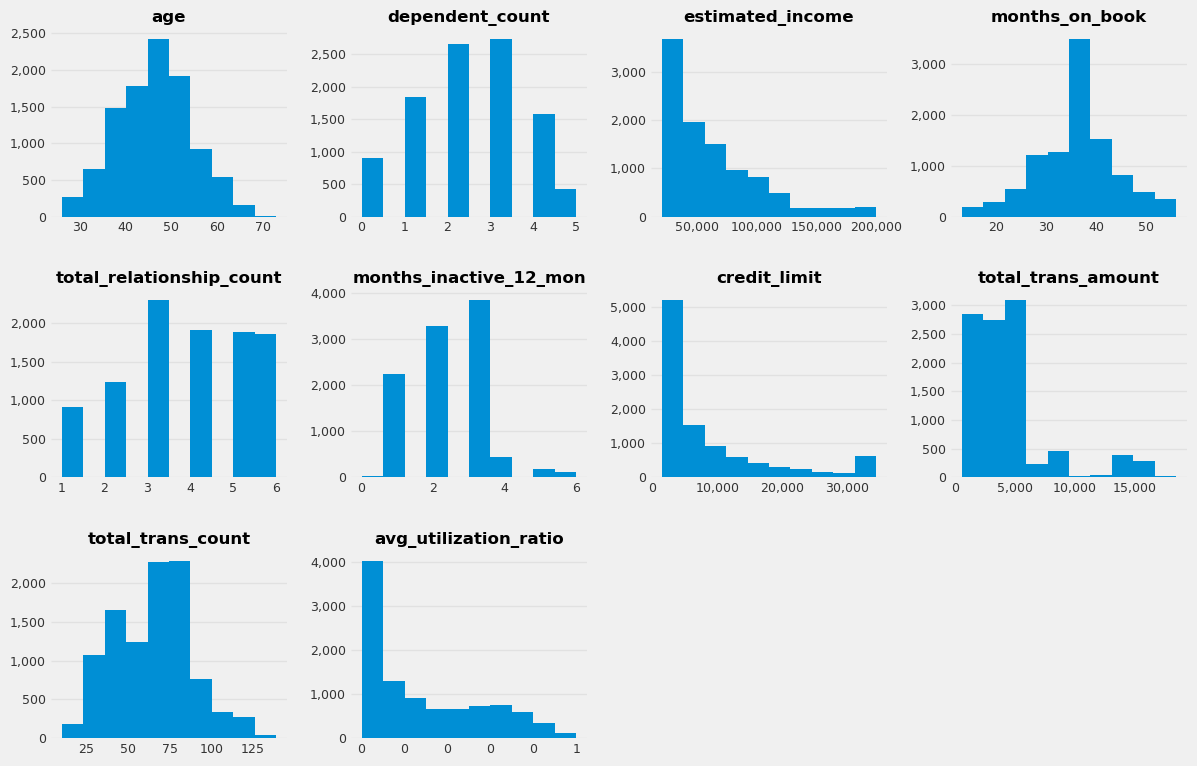

In [5]:
# Set the plot style, create a 4x4 grid of subplots, and adjust layout
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 10))
fig.tight_layout(pad=0)

# Flatten axes array and iterate over each subplot and column
axs = axs.flatten()
for ax, column in zip(axs, customers_numeric.columns):
    
    # Plot histograms for each numeric column and style the titles
    customers[column].hist(ax=ax)
    ax.set_title(column, fontsize=12, fontweight='bold')

    # Remove spines, customize tick parameters, and adjust gridlines
    ax.spines[:].set_visible(False)
    ax.tick_params(axis='both', labelcolor='#333333', labelsize=9, length=0)
    ax.grid(False)
    ax.yaxis.grid(True, alpha=0.4)
    
    # Apply the custom tick formatting to both x and y axes
    ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
    ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Remove unused subplots
for ax in axs[len(customers_numeric.columns):]:
    fig.delaxes(ax)

# Add vertical space between subplots and display the plot
plt.subplots_adjust(hspace=0.4)
plt.show()

Regarding distributions, variables such as `age` and `months_on_book` are closer to a normal distribution, whereas others are skewed.

## 3. Feature Engineering

After performing EDA and exploring variables, it's time to address the categorical columns:
* The `gender` column contains only `2` unique values, `M` and `F`, which we can replace with `1s` and `0s`. On the other hand, `education_level` contains `6` unique values that can be ranked from lowest to highest. We can replace each level with a corresponding number, respecting this order.
* Since the values in the `marital_status` column do not have a natural order of magnitude, we can't rank them. Therefore, we'll use one-hot encoding to create dummy variables from this column and then drop the original variable.

Before making any modifications, it's important to create a copy of the original DataFrame. We'll make all modifications in the copy and leave the original DataFrame untouched, so we can use it to analyze the results later.

In [6]:
# Create a copy of the original DataFrame and convert 'gender' to numerical values
customers_modif = customers.copy()
customers_modif['gender'] = customers_modif['gender'].apply(lambda x: 1 if x=='M' else 0)

# Replace 'education_level' with corresponding numerical values
customers_modif.replace({'Uneducated': 0, 'High School': 1, 'College': 2,
                         'Graduate': 3, 'Post-Graduate': 4, 'Doctorate': 5}, inplace=True)

# Create dummy variables for 'marital_status'
customers_modif = pd.get_dummies(customers_modif, columns=['marital_status'], drop_first=True)

# Display the shape and the first few rows of the dataset after modifications
print(f"The DataFrame's shape after modifications: {customers_modif.shape}")
customers_modif.head()

The DataFrame's shape after modifications: (10127, 15)


,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,True,False,False
1,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,False,True,False
2,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,True,False,False
3,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,False,False,True
4,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,True,False,False


The modified DataFrame has `10,127` rows and `15` columns. Also, the `gender` column is now binary, `education_level` is numeric, and `marital_status` has been one-hot encoded into `marital_status_Married`, `marital_status_Single`, and `marital_status_Unknown`.

## 4. Data Scaling

Note that we have differently scaled data across the DataFrame. For instance, the `estimated_income` column contains numbers ranging from thousands to hundreds of thousands, while the `dependent_count` column contains numbers from `1` to `5`. Therefore, we need to transform the data so that all values are on the same scale.

In [7]:
# Assign the modified DataFrame to X
X = customers_modif

# Initialize and apply StandardScaler to the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Display the first 3 scaled rows
X_scaled[:3]

array([[-0.16540558,  1.05995565,  0.50336813, -0.75221102,  0.1758098 ,
         0.38462088,  0.76394261, -1.32713603,  0.4466219 , -0.95970657,
        -0.97389518, -0.77588223,  1.07733799, -0.79850685, -0.28260887],
       [ 0.33357038, -0.9434357 ,  2.04319867,  0.66278684, -0.96716585,
         1.01071482,  1.40730617, -1.32713603, -0.04136665, -0.91643261,
        -1.35734038, -0.61627565, -0.92821381,  1.2523374 , -0.28260887],
       [ 0.58305837,  1.05995565,  0.50336813,  0.66278684,  0.78539682,
         0.00896451,  0.12057905, -1.32713603, -0.5736978 , -0.74098169,
        -1.91120566, -0.99715499,  1.07733799, -0.79850685, -0.28260887]])

## 5. Choosing K

Finally, our dataset is ready for machine learning. The next step is to determine the best number of clusters for segmentation using the inertia metric.

We will create several models and compute the inertia for each. Then, we can plot the **Elbow Curve** to decide the number of clusters to use for segmenting the customers. Once that is done, we can perform the actual clustering.

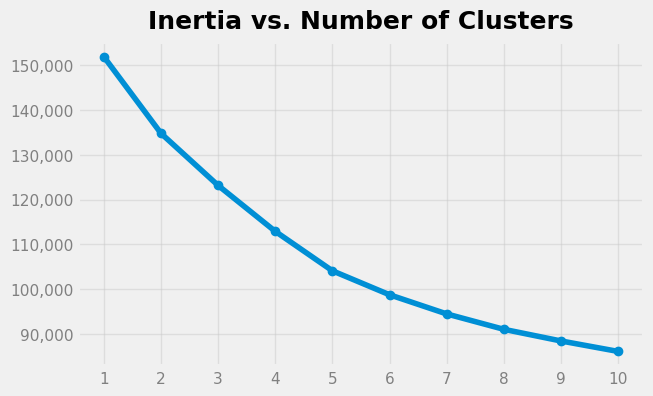

In [8]:
# Convert the scaled data to a DataFrame, and initialize a list to store inertia values
X = pd.DataFrame(X_scaled)
inertias = []

# Compute K-Means for k=1 to k=10 and store the inertia for each
for k in range(1, 11):
    model = KMeans(n_clusters=k, n_init=10)
    y = model.fit_predict(X)
    inertias.append(model.inertia_)

# Plot the inertia values using a line graph
plt.figure(figsize=(6.5, 4))
plt.plot(range(1, 11), inertias, marker='o')

# Set the title and customize tick labels and gridlines
plt.title('Inertia vs. Number of Clusters', weight='bold', size=18, pad=10)
plt.xticks(ticks=range(1, 11), labels=range(1, 11), size=11, color='gray')
plt.yticks(size=11, color='gray')
plt.grid(alpha=0.5)

# Apply the custom tick formatting to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Display the plot
plt.show()

As the number of clusters increased from `1` to `10`, the inertia decreased consistently. The most significant drop occurred between `1` and `2` clusters, going from approximately `151,905` to `134,791`. The rate of decrease becomes less pronounced after about `5` clusters. Hence, we'll proceed with `6` clusters.

In [9]:
# Fit K-Means model with 6 clusters and a fixed random state to predict cluster assignments
model = KMeans(n_clusters=6, n_init=10, random_state=42)
y = model.fit_predict(X_scaled)

# Display unique cluster labels
np.unique(y)

array([0, 1, 2, 3, 4, 5])

As we can see, our cluster numbers range from `0` to `5`. We'll add `1` to each number so that the clusters are labeled from `1` to `6` for clarity.

## 6. Analyzing the Results

All that's left now is to analyze the results. We need to examine how the variables used in clustering differ from one cluster to another to better understand what each cluster represents.

Our goal is to identify the most important characteristics of each cluster, and determine how they can impact business and marketing strategies for each type of customer.

First, let's create a column named `CLUSTER` in our original dataset.

In [10]:
# Add cluster labels to the original DataFrame and count the number of customers in each cluster
customers['CLUSTER'] = y + 1
customers['CLUSTER'].value_counts()

CLUSTER
1    2826
6    2449
5    1771
4    1444
2     908
3     729
Name: count, dtype: int64

We can see that clusters `1` and `6` are the largest, with over `2,000` customers each, while clusters `2` and `3` are the smallest, with fewer than `1,000` customers each.

Considering the numeric variables, we'll examine the average value of each variable per cluster. We'll group the data by cluster and then plot a bar chart for each numeric column.

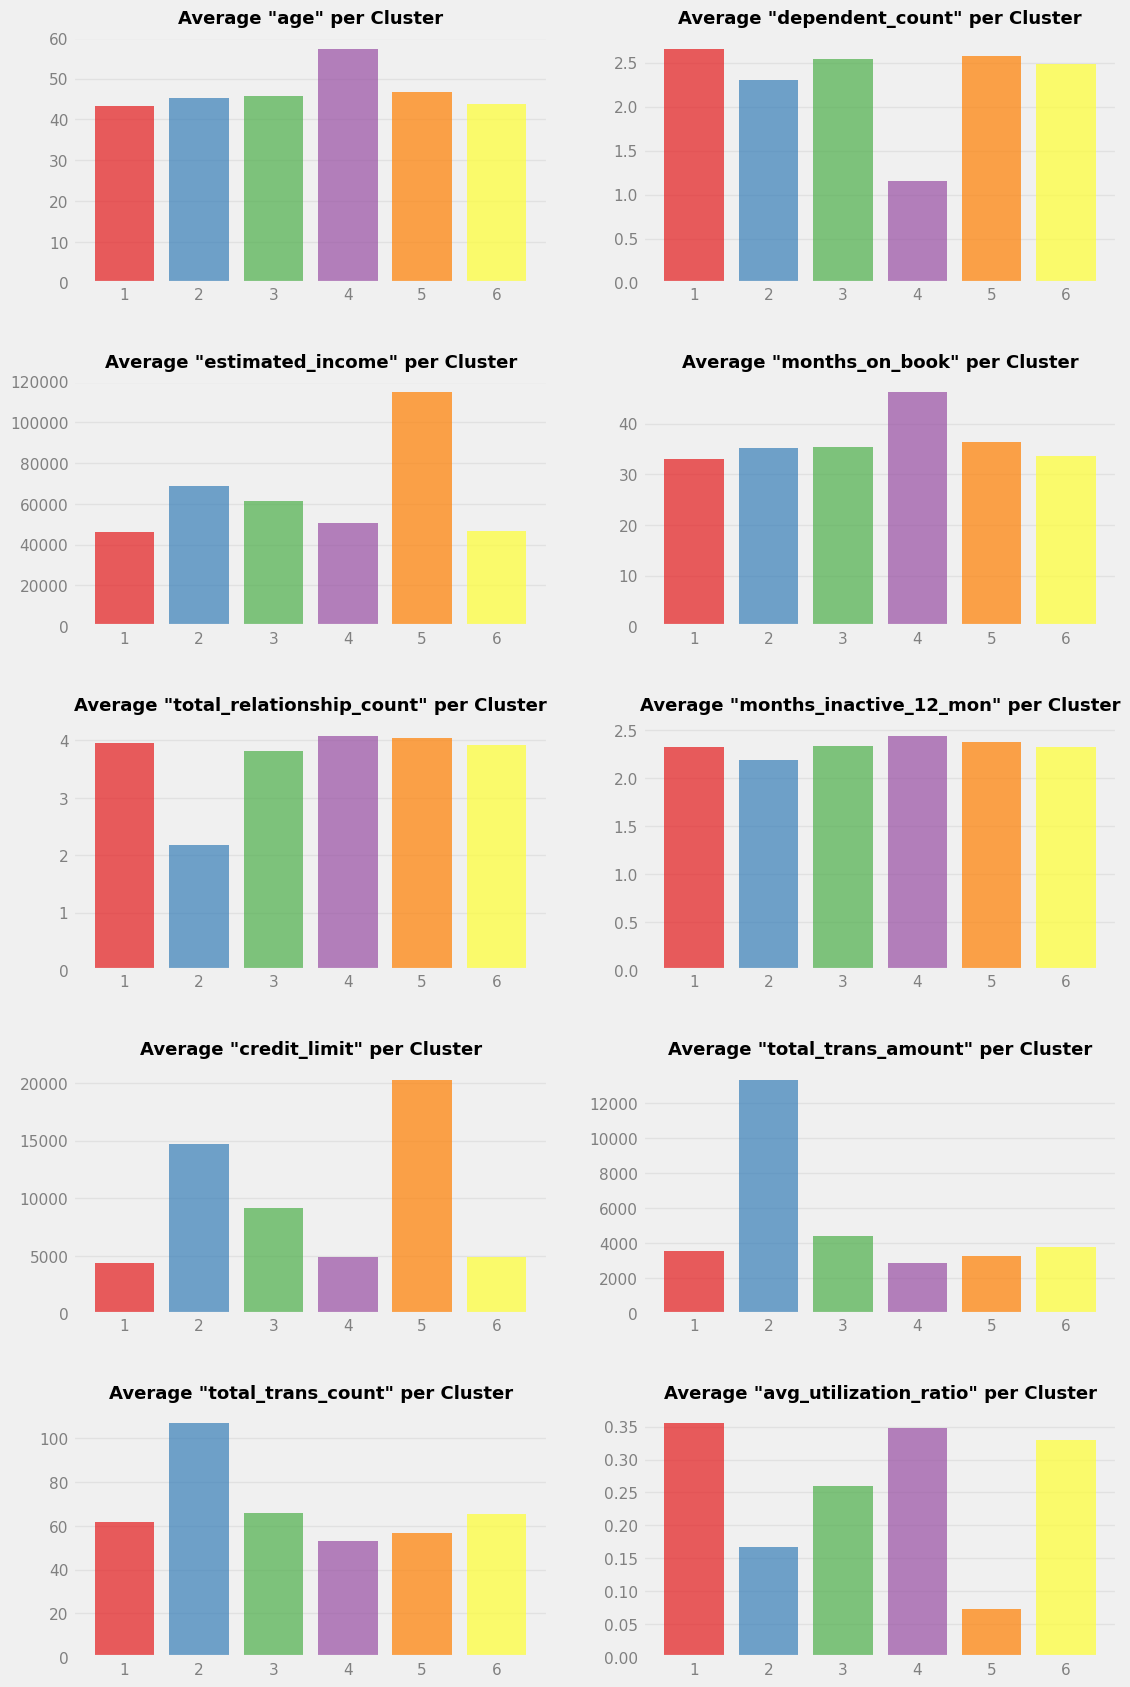

In [11]:
# Create a figure for plotting
fig = plt.figure(figsize=(12, 20))

# Iterate through each numeric column
for i, column in enumerate(customers_numeric.columns, start=1):
    
    # Compute the average value of each numeric column per cluster
    df_plot = customers.groupby('CLUSTER')[column].mean()
    
    # Add a subplot for each numeric column
    ax = fig.add_subplot(5, 2, i)
    
    # Create a bar plot of the average values per cluster
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha=0.7)
    ax.set_title(f'Average "{column}" per Cluster', weight='bold', size=13, pad=10)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True, alpha=0.4)
    ax.tick_params(axis='both', labelsize=11, labelcolor='gray')

# Add vertical space between subplots and display the plot
plt.subplots_adjust(hspace=0.4)
plt.show()

Based on the charts above, here are some concise insights:
* In contrast to `Cluster 5`, `Cluster 1` has the lowest credit limit and estimated income but the highest utilization ratio.
* `Cluster 2` has the highest amount of money transacted and the most credit card transactions, along with the fewest contacts with the company.
* `Cluster 4` consists of customers with the longest tenure, the fewest dependents, and the oldest clients.

For the numerical variables with the strongest correlations observed earlier, we can use scatter plots to visualize these correlations, color-coded by clusters. This will help us analyze how the clusters are distributed across various regions of the charts.

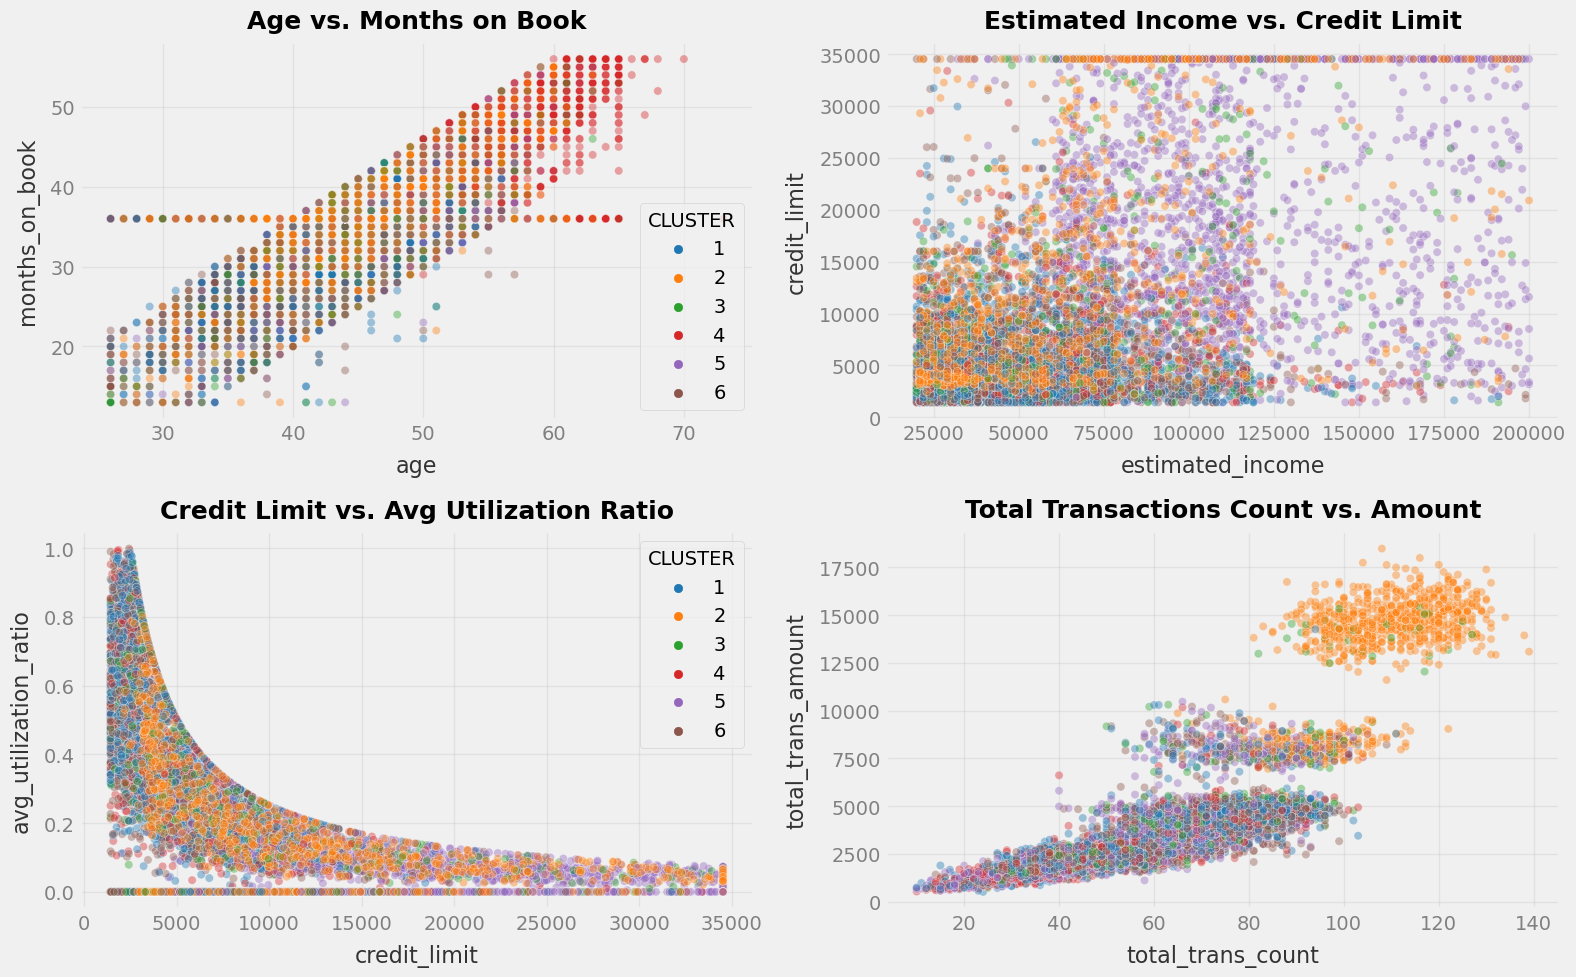

In [12]:
# Create a 2x2 grid of subplots with specified figure size
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
axes = [ax1, ax2, ax3, ax4]

# Plot scatter plots for each pair of variables, color-coded by clusters
sns.scatterplot(x='age', y='months_on_book', hue='CLUSTER',
                data=customers, palette='tab10', alpha=0.4, ax=ax1)
ax1.set_title('Age vs. Months on Book', size=18, pad=10, weight='bold')

sns.scatterplot(x='estimated_income', y='credit_limit', hue='CLUSTER',
                data=customers, palette='tab10', alpha=0.4, ax=ax2, legend=False)
ax2.set_title('Estimated Income vs. Credit Limit', size=18, pad=10, weight='bold')

sns.scatterplot(x='credit_limit', y='avg_utilization_ratio', hue='CLUSTER',
                data=customers, palette='tab10', alpha=0.4, ax=ax3)
ax3.set_title('Credit Limit vs. Avg Utilization Ratio', size=18, pad=10, weight='bold')

sns.scatterplot(x='total_trans_count', y='total_trans_amount', hue='CLUSTER',
                data=customers, palette='tab10', alpha=0.4, ax=ax4, legend=False)
ax4.set_title('Total Transactions Count vs. Amount', size=18, pad=10, weight='bold')

# Customize appearance for each subplot
for ax in axes:
    ax.set_xlabel(ax.get_xlabel(), color='#333333', labelpad=8, size=16)
    ax.set_ylabel(ax.get_ylabel(), color='#333333', labelpad=8, size=16)
    ax.tick_params(axis='both', labelcolor='gray')
    ax.grid(alpha=0.4)

# Adjust spacing between subplots and display them
plt.subplots_adjust(hspace=0.37)
plt.tight_layout()
plt.show()

Here are some insights based on the scatter plots:
- Older customers tend to have longer tenure, particularly in `Cluster 4`, which has older customers than the other clusters.
- Although there is no distinct pattern, many customers across various clusters have credit limits under `20,000 USD` and estimated incomes below `125,000 USD`. Additionally, there is a noticeable group with credit limits around `35,000 USD` and a wide range of estimated incomes.
- As credit limits increase, customers' utilization ratios decrease rapidly before leveling off, indicating a negative exponential relationship between the two variables.
- There are two distinct transaction behaviors – one group with low to medium transaction counts and total amounts, and another with high transaction counts and amounts. The latter group primarily consists of customers from `Cluster 2`.

Next, for the categorical columns, we'll plot the percentage distribution of each variable in each cluster. This will allow us to verify if a particular cluster is mostly composed of men, or of married people only, for example.

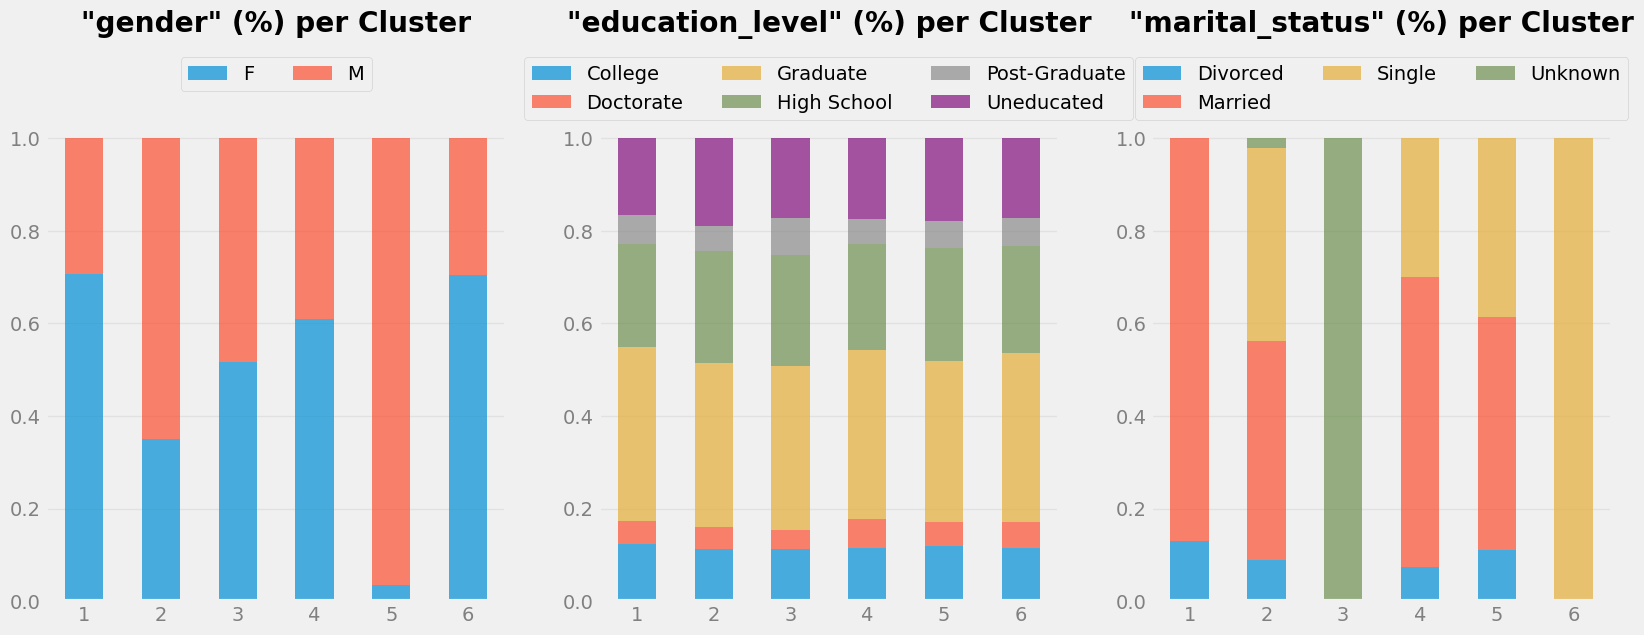

In [13]:
# Select categorical columns from the DataFrame
customers_categorical = customers.select_dtypes(include=['object'])

# Create a figure for subplots
fig = plt.figure(figsize=(18, 6))

# Iterate over categorical columns
for i, col in enumerate(customers_categorical, start=1):
    
    # Create a crosstab for the current column, normalized by cluster
    plot_df = pd.crosstab(index=customers['CLUSTER'], columns=customers[col],
                          values=customers[col], aggfunc='size', normalize='index')
    
    # Add subplot for the current column, and plot the stacked bar chart
    ax = fig.add_subplot(1, 3, i)
    plot_df.plot.bar(stacked=True, ax=ax, alpha=0.7)
    
    # Set the title and styling for the subplot
    ax.set_title(f'"{col}" (%) per Cluster', weight='bold', pad=60)
    ax.set_xlabel('')
    
    # Customize grid and tick parameters
    ax.xaxis.grid(False)
    ax.yaxis.grid(True, alpha=0.4)
    ax.tick_params(axis='x', rotation=0)
    ax.tick_params(axis='both', labelcolor='gray')
    
    # Center the legend above the subplot, with 3 columns for legend entries
    ax.legend(bbox_to_anchor=(0.5, 1.14), loc='upper center', ncol=3)

# Display the plot
plt.show()

Considering the categorical variables, we notice that the education levels are well divided among the clusters without significant differences. Moreover, `Cluster 1` is composed almost entirely of married people, while the marital status of customers in `Cluster 3` is unknown. `Cluster 5` is predominantly male, and `Cluster 6` consists entirely of single people.

## 7. Conclusion

In this project, we acted as data scientists for a credit card company, working with a dataset of the company’s clients. Our task was to segment them into groups using the **K-means** algorithm to apply targeted business strategies. The dataset had `10,127` rows and `14` columns, with no missing values. We omitted the unique client identifier, as it wasn't needed for segmentation. The remaining columns included both categorical and numerical data. Moreover, we explored the dataset by displaying categorical value frequencies, examining numeric correlations via a heatmap, and visualizing distributions with histograms.

After conducting EDA, we created a copy of the original DataFrame to address the categorical columns, leaving the original intact for future analysis. The modified DataFrame contains `10,127` rows and `15` columns – the `gender` column is binary, the `education_level` is numeric, and `marital_status` has been one-hot encoded into `marital_status_Married`, `marital_status_Single`, and `marital_status_Unknown`.

Before building our clustering model, we scaled the data and determined the optimal number of clusters using the inertia metric. After plotting the **Elbow Curve**, we observed a consistent decrease in inertia as the number of clusters increased from `1` to `10`. Since the rate of decrease slowed more significantly after `5` clusters, we decided to use `6` clusters.

To analyze the results, we examined how the clustering variables differ across clusters to understand their characteristics and impact on business and marketing strategies. We created a new column, `CLUSTER`, in our original dataset, labeling the clusters from `1` to `6` for clarity. Clusters `1` and `6` are the largest, each with over `2,000` customers, while clusters `2` and `3` are the smallest, with fewer than `1,000` customers each.

Considering the numeric variables, we calculated the average value for each variable per cluster, grouping the data accordingly and plotting a bar chart for each numeric column. For the variables with the strongest correlations, we used scatter plots to visualize these relationships, color-coded by clusters, which helped us analyze the clusters' distribution across the charts. Additionally, we plotted the percentage distribution of each categorical variable within each cluster to verify their composition.

As requested by the credit card company, we identified the key characteristics of each cluster and provided insights and suggestions for each one. Ultimately, each customer has been assigned to a specific cluster:

- `Cluster 1` – The largest cluster, with around `70%` female customers, mostly married, low credit limits, and a very high utilization rate. We suggest offering credit management tools and financial literacy programs to help manage their utilization rates.
- `Cluster 2` – The second smallest cluster, with over `60%` male customers, high credit limits, the highest transaction volume, and moderate utilization rates. They also have the fewest contacts with the company. We suggest offering premium loyalty rewards and low-touch services for high-value customers.
- `Cluster 3` – The smallest cluster, with a balanced gender split, average credit limits, high utilization rates, and unknown marital status. We suggest personalized outreach to improve engagement and gather more demographic insights.
- `Cluster 4` – Over `60%` are married, the oldest group overall, with the fewest dependents, longest tenure, low credit limits, and very high utilization rates. We suggest offering financial planning services and retention strategies for loyal, long-term customers.
- `Cluster 5` – Mostly male, with the majority either married or single, the highest estimated income, very high credit limits, and the lowest utilization rate. We suggest promoting investment and savings products tailored to affluent customers.
- `Cluster 6` – The second largest cluster, with around `70%` females, all single, low credit limits, and very high utilization rates. We suggest offering credit management tools and financial literacy programs to help manage their utilization rates.